<a href="https://colab.research.google.com/github/jaympatel481/Analysis-of-the-COLONOMICS-Dataset/blob/main/COLONOMICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unxz /content/CLX_clinical_data.csv.xz
!unxz /content/CLX_CN_segments_2017Jan20.txt.xz
!unxz /content/CLX_somatic_mutations.csv.xz
!unxz /content/CLX_methylation_betas_2014Apr25.txt.xz
!unxz /content/CLX_methylation_cpg_annot.txt.xz
!unxz /content/CLX_miRNAs_counts_2022Mar14.txt.xz
!unxz /content/CLX_Expression_2014Nov24.txt.xz
!unxz /content/CLX_Expression_PC1_2014Nov24.txt.xz


In [ ]:
import pandas as pd
clin = pd.read_table("/content/CLX_clinical_data.csv",sep=";")
cn=pd.read_table("/content/CLX_CN_segments_2017Jan20.txt")
som = pd.read_table("/content/CLX_somatic_mutations.csv", index_col=0)
mbeta = pd.read_table("/content/CLX_methylation_betas_2014Apr25.txt",sep=",", index_col=0)
mirna = pd.read_table("/content/CLX_miRNAs_counts_2022Mar14.txt")
mirna.index
u219 = pd.read_table("/content/CLX_Expression_2014Nov24.txt")
genexp = pd.read_table("/content/CLX_Expression_PC1_2014Nov24.txt")

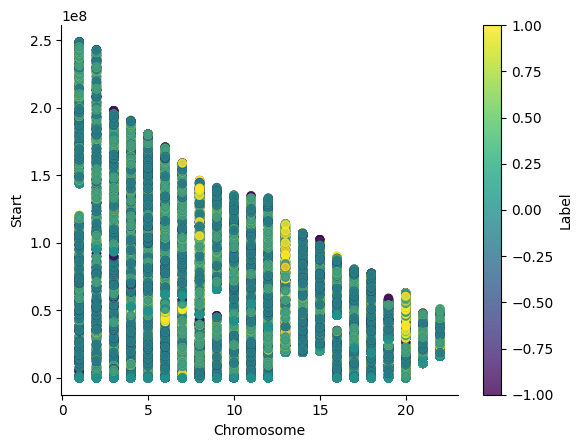

In [ ]:
from matplotlib import pyplot as plt

# Create scatter plot with color mapped to 'Mean' column
cnplot = cn.copy()
cn.plot(kind='scatter',
        x='Chromosome',
        y='Start',
        s=32,
        alpha=.8,
        c='Label',
        cmap='viridis')

# Clean up plot appearance
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


In [ ]:
import pandas as pd

# Create sample mapping dictionary
sample_map = {}
for idx, row in clin.iterrows():
    sample_id = row['id_clx']
    if '_T' in sample_id:
        base_id = sample_id.replace('_T','')
        sample_map[base_id] = {'T': sample_id, 'N': f"{base_id}_N"}


In [ ]:
def integrate_omics(base_id):
    try:
        return {
            'clinical': clin[clin['id_clx'].isin([f"{base_id}_T", f"{base_id}_N"])],
            'cnv': cn[cn['ID'] == base_id],
            'mutations': som[[col for col in som if col.startswith(base_id)]],
            'expression': genexp[[f"{base_id}_T", f"{base_id}_N"]],
            'mirna': mirna[[f"{base_id}_T", f"{base_id}_N"]]
        }
    except KeyError:
        return None

In [ ]:
paired_samples = [s.replace('_T','') for s in clin[clin['type']=='Tumor']['id_clx']]
print(f"Complete pairs: {len([p for p in paired_samples if f'{p}_N' in clin['id_clx'].values])}/100")

# Get clinical tumor base IDs
clinical_tumor_base = clin[clin['type'] == 'Tumor']['id_clx'].str.replace('_T$', '', regex=True).unique()

# Get CNV IDs
cnv_ids = cn['ID'].unique()

# Find discrepancies
missing_in_clinical = [cid for cid in cnv_ids if cid not in clinical_tumor_base]
missing_in_cnv = [cid for cid in clinical_tumor_base if cid not in cnv_ids]

print(f"CNV IDs missing in clinical: {missing_in_clinical}")
print(f"Clinical tumor IDs missing in CNV: {missing_in_cnv}")


Complete pairs: 100/100
CNV IDs missing in clinical: []
Clinical tumor IDs missing in CNV: ['A2004']


In [ ]:
from scipy.stats import zscore

def find_cnv_hotspots():
    # Segment consolidation
    cnv_features = cn.groupby(['Chromosome', 'Start', 'End', 'Label']).size().reset_index(name='Count')
    cnv_features['Zscore'] = zscore(cnv_features['Count'])
    return cnv_features[cnv_features['Zscore'] > 2]

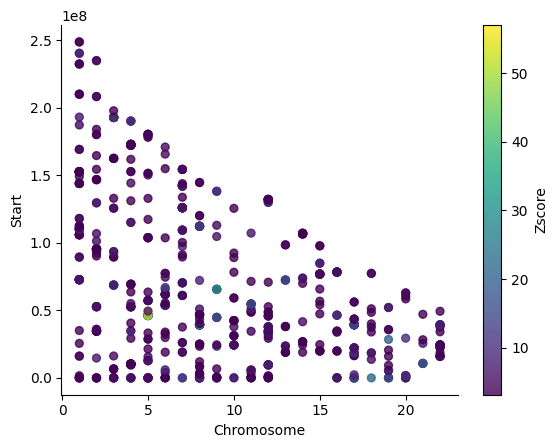

In [ ]:
from matplotlib import pyplot as plt

# Create scatter plot with color mapped to 'Mean' column
cnplot = find_cnv_hotspots()
cnplot.plot(kind='scatter',
        x='Chromosome',
        y='Start',
        s=32,
        alpha=.8,
        c='Zscore',
        cmap='viridis')

# Add colorbar for reference
# plt.colorbar(label='Mean Value')

# Clean up plot appearance
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


In [ ]:
def build_mutation_network():
    # Extract patient columns (numeric mutation status columns)
    metadata_cols = ['variant_c', 'variant_type', 'rs', 'functionGVS', 'gene', 'gene_list']
    patient_cols = [col for col in som.columns if col not in metadata_cols]

    # Filter and validate numeric columns
    numeric_cols = som[patient_cols].select_dtypes(include='number').columns
    if len(numeric_cols) != len(patient_cols):
        print(f"Warning: {len(patient_cols)-len(numeric_cols)} non-numeric columns excluded")

    # Calculate mutation prevalence
    mut_prevalence = som[numeric_cols].sum(axis=1)
    prevalent_genes = som.loc[mut_prevalence > 0.1 * len(numeric_cols), 'gene']

    # Get top 5% variable genes from expression
    gene_var = genexp.var(axis=1)
    top_var = gene_var.nlargest(int(0.05 * len(genexp))).index

    # Combine features and remove duplicates
    network_features = pd.Index(
        prevalent_genes.tolist() + top_var.tolist()
    ).drop_duplicates().tolist()

    return network_features


In [ ]:
def mirna_target_network():

    # Verify sample alignment
    common_samples = mirna.columns.intersection(genexp.columns)
    mirna_df = mirna[common_samples]
    gene_exp_df = genexp[common_samples]

    # Perform PCA on miRNA data (samples in columns)
    pca = PCA(n_components=50)
    mirna_pca = pca.fit_transform(mirna_df.T)  # Transpose to samples x features

    # Prepare matrices for correlation
    miRNA_components = mirna_pca.T  # Now 50 components x samples
    gene_expression = gene_exp_df.values  # Genes x samples

    # Calculate correlations
    correlation_matrix = np.corrcoef(np.concatenate([miRNA_components, gene_expression]))[:50, 50:]

    return pd.DataFrame(
        correlation_matrix,
        columns=gene_exp_df.index,
        index=[f"miRNA_PC{i}" for i in range(1, 51)]
    )


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


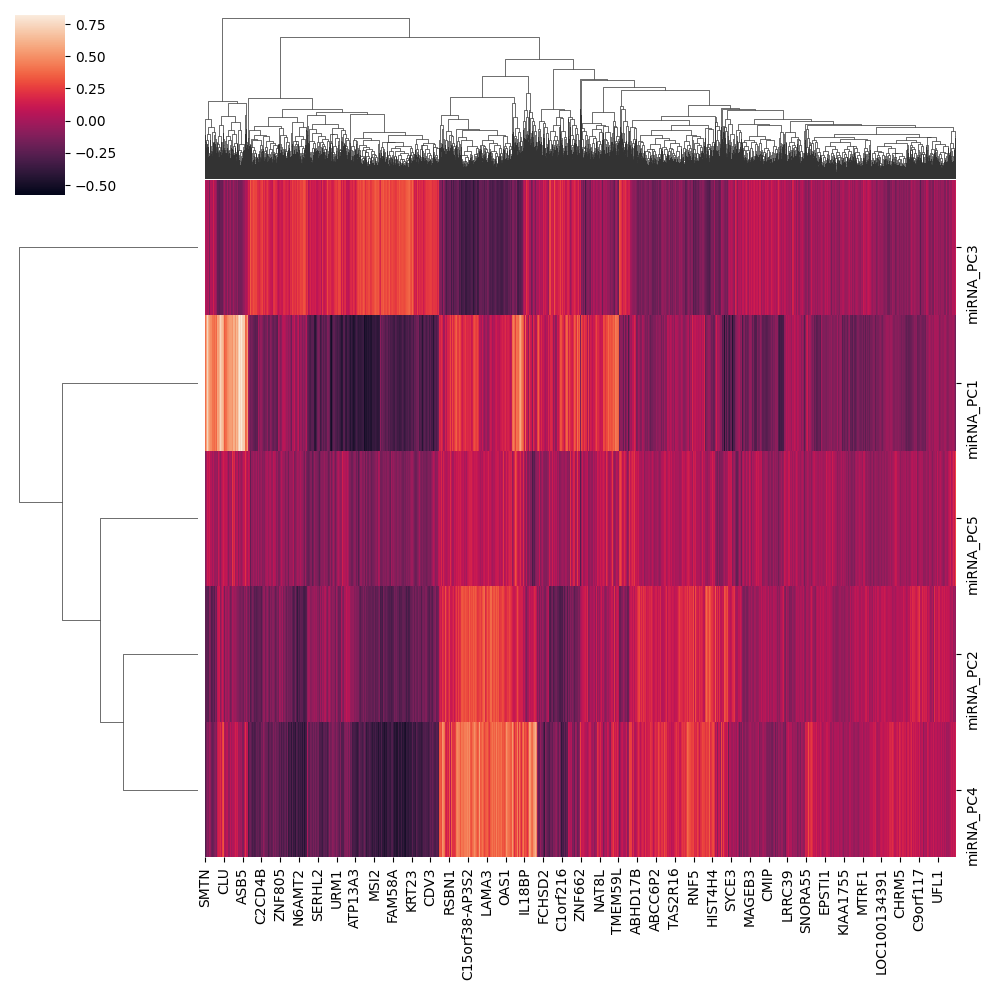

In [ ]:
import seaborn as sns
a = mirna_target_network()
sns.clustermap(a)

In [ ]:
def cnv_stromal_inference():

    # Calculate Proportion of Genome Altered (PGA)
    pga = cn.groupby('ID').apply(
        lambda x: (x['End'] - x['Start']).sum() / 3.3e9  # Human genome size
    ).reset_index(name='PGA')

    # Cluster samples based on PGA
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=4).fit(pga[['PGA']])

    return pga.assign(stromal_group=kmeans.labels_)


In [ ]:
import seaborn as sns
stromal_groups = cnv_stromal_inference()[['ID', 'stromal_group']]
# Merge stromal groups with clinical data
def build_group_networks(group_col):
    networks = {}
    for group in stromal_groups[group_col].unique():
        samples = stromal_groups[stromal_groups[group_col] == group]['id_clx']

        # Subset mutation data
        group_mutations = som[samples].sum(axis=1)
        mut_genes = group_mutations[group_mutations > 0.1*len(samples)].index

        # Build co-expression network
        corr_matrix = genexp[samples].T.corr()

        networks[group] = {
            'mut_genes': mut_genes,
            'corr_matrix': corr_matrix
        }
    return networks


<ipython-input-11-a52307a2fa17>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pga = cn.groupby('ID').apply(


In [ ]:
def compare_networks(network_dict):
    from networkx import graph_edit_distance

    metrics = {}
    for group, net in network_dict.items():
        G = nx.from_pandas_adjacency(net['corr_matrix'] > 0.8)
        metrics[group] = {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'centrality': nx.betweenness_centrality(G)
        }

    # Calculate inter-group distances
    groups = list(network_dict.keys())
    distance_matrix = pd.DataFrame(
        index=groups, columns=groups,
        data=[[graph_edit_distance(network_dict[i], network_dict[j])
             for j in groups] for i in groups]
    )

    return metrics, distance_matrix


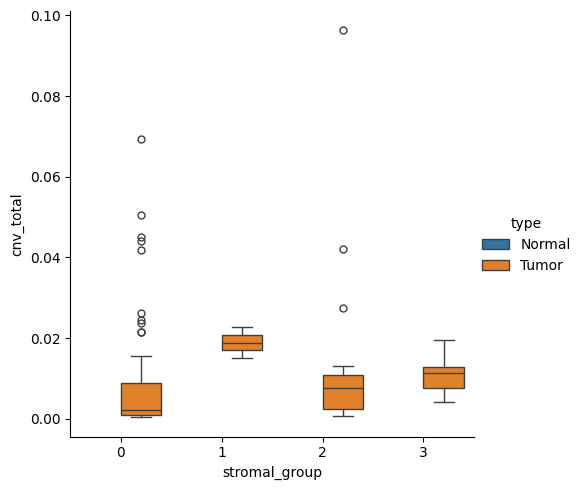

In [ ]:
import pandas as pd

# Convert comma decimals to float
clin['cnv_total'] = (
    clin['cnv_total']
    .astype(str)  # Ensure string type
    .str.replace(',', '.', regex=False)  # Replace commas with periods
    .astype(float)  # Convert to numeric
)

# Verify conversion
clin['base_id'] = clin['id_clx'].str.replace('_T', '').str.replace('_N', '').str.replace('_M', '')
clinical_stromal = clin.merge(
    stromal_groups,
    left_on='base_id',
    right_on='ID',
    how='inner'
)

# Plot clinical feature distributions
sns.catplot(
    data=clinical_stromal,
    x='stromal_group',
    y='cnv_total',
    hue='type',
    kind='box',
)
plt.show()

In [ ]:
from scipy.stats import mannwhitneyu
mannwhitneyu(clinical_stromal[clinical_stromal['stromal_group'] == 2]['cnv_total'].dropna().values, clinical_stromal[clinical_stromal['stromal_group'] == 3]['cnv_total'].dropna().values)

MannwhitneyuResult(statistic=np.float64(347.0), pvalue=np.float64(0.0019923600403379408))

In [ ]:
!pip install ensmallen -q

In [ ]:
import numpy as np
from ensmallen import Graph

def build_stromal_network(group_adj_matrix):
    """Build Ensmallen graph from adjacency matrix with node features."""

    # Convert adjacency matrix to edge list
    edges = np.argwhere(group_adj_matrix > 0)
    weights = group_adj_matrix[edges[:,0], edges[:,1]]

    # Create directed graph with edge weights
    graph = Graph.from_edge_list(
        edges.astype(np.uint32),
        directed=False,
        edge_weights=weights.astype(np.float32)
    )

    return graph


Processing stromal group 0
Data types: gene1     object
gene2     object
change     int64
dtype: object
Sample values: 18069   -1
21661   -1
28681   -1
29188   -1
29778   -1
Name: change, dtype: int64


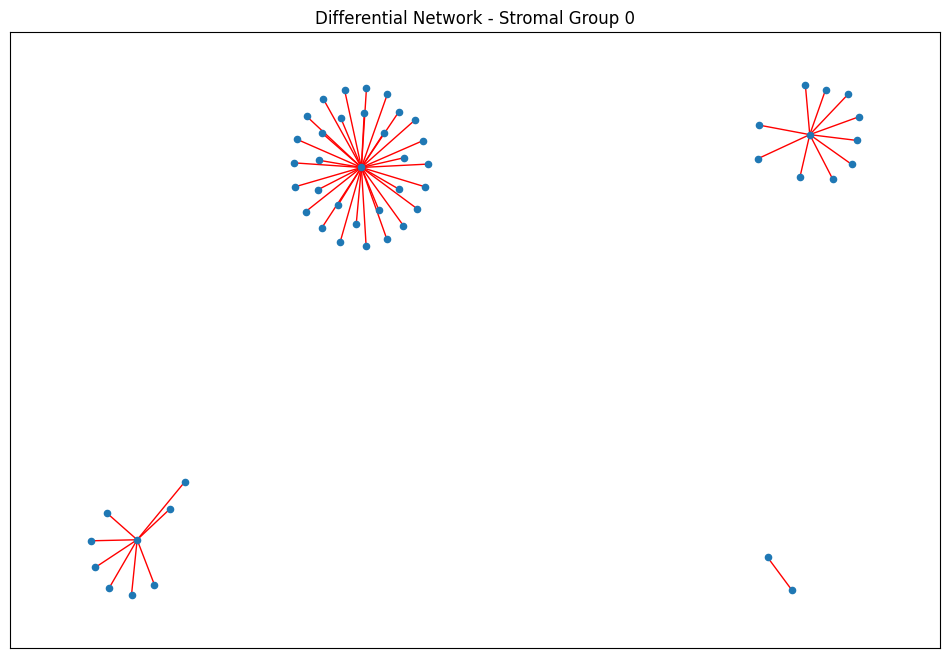

Processing stromal group 2
Data types: gene1     object
gene2     object
change     int64
dtype: object
Sample values: 53    -1
83    -1
115   -1
117   -1
122   -1
Name: change, dtype: int64


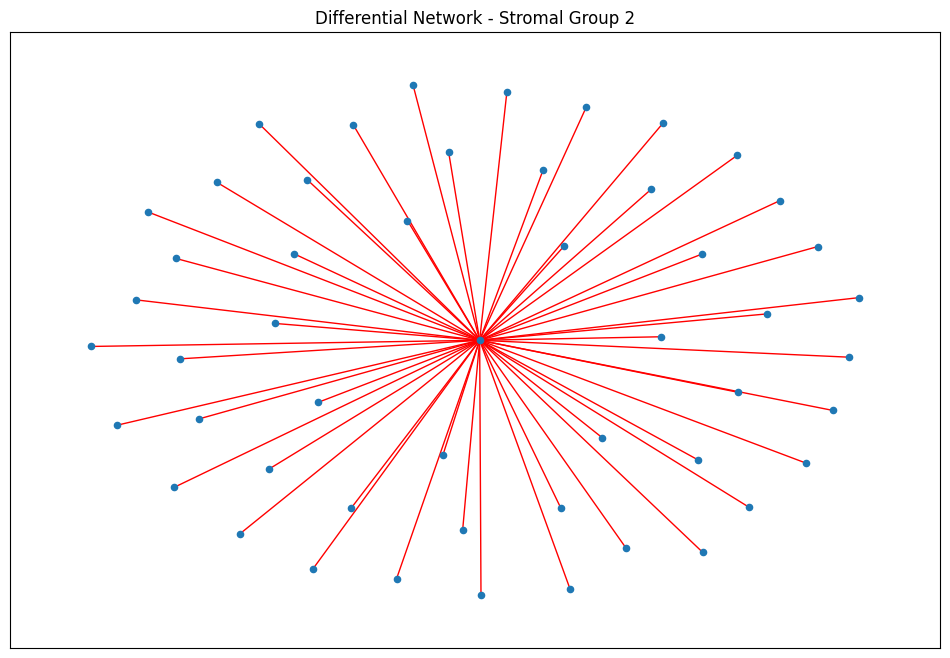

Processing stromal group 3
Data types: gene1     object
gene2     object
change     int64
dtype: object
Sample values: 7    -1
10   -1
15    1
19   -1
20   -1
Name: change, dtype: int64


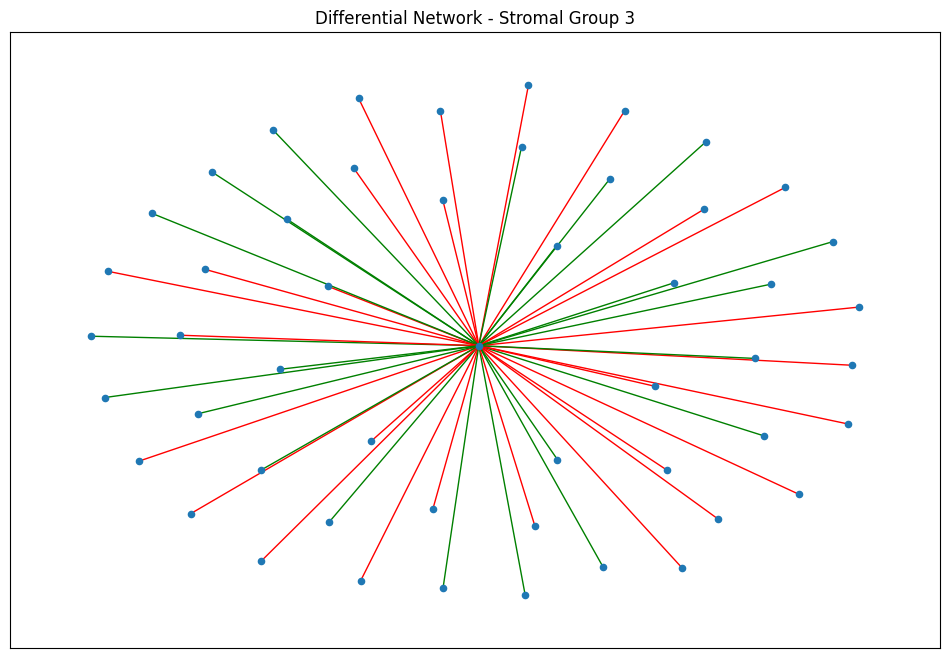

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import networkx as nx


def create_adjacency_matrix(samples, threshold=0.7):
    """Build co-expression network from expression data"""
    subset = genexp[samples].T
    corr_matrix = subset.corr(method='spearman').abs()
    adj_matrix = (corr_matrix > threshold).astype(int)
    return csr_matrix(adj_matrix.values)

def get_group_samples(stromal_group, sample_type):
    """Get sample IDs for specific stromal group and type"""
    return clinical_stromal[
        (clinical_stromal["stromal_group"] == stromal_group) &
        (clinical_stromal["type"] == sample_type)
    ]["id_clx"].tolist()

# --------------------------------------------------
# 3. Differential Network Analysis
# --------------------------------------------------

def real_differential_analysis(stromal_group):
    # Get sample IDs
    tumor_samples = [s for s in get_group_samples(stromal_group, "Tumor")
                    if s in genexp.columns]
    normal_samples = [s for s in get_group_samples(stromal_group, "Normal")
                     if s in genexp.columns]

    # Build networks as DataFrames with gene indices
    tumor_adj = pd.DataFrame(
        create_adjacency_matrix(tumor_samples).toarray(),
        index=genexp.index,
        columns=genexp.index
    )

    normal_adj = pd.DataFrame(
        create_adjacency_matrix(normal_samples).toarray(),
        index=genexp.index,
        columns=genexp.index
    )

    # Find common genes (should be identical in this case)
    common_genes = tumor_adj.index.intersection(normal_adj.index)

    # Align matrices using DataFrame indexing
    tumor_adj_aligned = tumor_adj.loc[common_genes, common_genes].values
    normal_adj_aligned = normal_adj.loc[common_genes, common_genes].values

    # Calculate differential edges
    diff_matrix = tumor_adj_aligned - normal_adj_aligned

    return pd.DataFrame(
        diff_matrix,
        index=common_genes,
        columns=common_genes
    )

# --------------------------------------------------
# 4. Visualization & Biological Interpretation
# --------------------------------------------------

def plot_real_network(diff_matrix, top_n=50, stromal_group=None):
    """Plot top differential connections"""
    # Get most altered edges
    edge_changes = pd.DataFrame({
        'gene1': np.repeat(diff_matrix.columns, len(diff_matrix)),
        'gene2': np.tile(diff_matrix.columns, len(diff_matrix)),
        'change': diff_matrix.values.flatten()
    }).query('change != 0')

    # Convert change column to numeric and handle non-numeric values
    edge_changes['change'] = pd.to_numeric(edge_changes['change'], errors='coerce')
    edge_changes = edge_changes.dropna(subset=['change'])  # Remove rows with NaN values
    print(f"Data types: {edge_changes.dtypes}")
    print(f"Sample values: {edge_changes['change'].head()}")
    # Now safely apply abs() after ensuring numeric values
    edge_changes['abs_change'] = edge_changes['change'].abs()
    top_edges = edge_changes.nlargest(top_n, 'abs_change')

    # Create graph
    G = nx.from_pandas_edgelist(
        top_edges,
        'gene1', 'gene2',
        edge_attr='change'
    )

    # Plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, edge_color=[
        'green' if d['change'] > 0 else 'red'
        for _, _, d in G.edges(data=True)
    ])
    plt.title(f"Differential Network - Stromal Group {stromal_group}")
    plt.show()


# --------------------------------------------------
# 5. Execution Pipeline
# --------------------------------------------------

# Get unique stromal groups with sufficient samples
valid_groups = clinical_stromal.groupby("stromal_group").filter(
    lambda x: (x["type"] == "Tumor").sum() > 5 and
              (x["type"] == "Normal").sum() > 5
)["stromal_group"].unique()

# Perform analysis for each valid group
for stromal_group in valid_groups:
    print(f"Processing stromal group {stromal_group}")

    # Run differential analysis
    diff_matrix = real_differential_analysis(stromal_group)

    # Generate visualization
    plot_real_network(diff_matrix, stromal_group=stromal_group)

    # Save results
    pd.DataFrame(diff_matrix,
                index=genexp.index,
                columns=genexp.index
    ).to_csv(f"diff_network_group_{stromal_group}.csv")


In [ ]:
diff_network_group_0 = pd.read_csv("/content/diff_network_group_0.csv")

,Unnamed: 0,TNFAIP8L1,OTOP2,C17orf78,LINC01098,SAMD7,ARRDC5,ERICH3,FAM86C1,HIST1H2BI,...,ZNF799,ZNF807,ZNF816,ZNF816-ZNF321P,ZNF846,ZNF890P,ZNF98,ZNRD1-AS1,ZRSR1,ZXDA
0,TNFAIP8L1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,OTOP2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C17orf78,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,LINC01098,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SAMD7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20065,ZNF890P,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20066,ZNF98,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20067,ZNRD1-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20068,ZRSR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
diff_network_group_0.set_index("Unnamed: 0", inplace=True)

In [ ]:
diff_network_group_2 = pd.read_csv("/content/diff_network_group_2.csv", index_col=0)
diff_network_group_3 = pd.read_csv("/content/diff_network_group_3.csv", index_col=0)

In [ ]:
!pip install lifelines -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.6 MB/s eta 0:00:00


In [ ]:
!pip install gseapy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 43.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load differential networks
adjs = [diff_network_group_0, 0, diff_network_group_2, diff_network_group_3]

import gseapy as gp

def pathway_analysis(group_id, diff_matrix, top_n=100):
    """Perform pathway enrichment on hub genes"""
    # Get top genes by differential connectivity
    edge_sum = diff_matrix.abs().sum(axis=1)
    top_genes = edge_sum.nlargest(top_n).index.tolist()

    # Run enrichment analysis
    enrichr_results = gp.enrichr(
        gene_list=top_genes,
        gene_sets=['KEGG_2021_Human', 'GO_Biological_Process_2021'],
        organism='Human'
    )

    # Save results
    enrichr_results.results.to_csv(f"pathways_group_{group_id}.csv")
    # Plot top pathways
    # print(enrichr_results.results)
    # if enrichr_results.results != None:
    # plt.figure(figsize=(10, 6))
    # gp.plot.barplot(enrichr_results.results, top_term=10)
    # plt.title(f"Pathway Enrichment - Stromal Group {group_id}")
    # plt.tight_layout()
    # plt.savefig(f"pathways_group_{group_id}.png", dpi=300)

    return enrichr_results.results

# Run for each group
for group in [0, 2, 3]:
    pathway_analysis(group, adjs[group])



In [ ]:
from lifelines import CoxPHFitter
import pandas as pd

def survival_analysis(clinical_df, group_diffs_dict):
    """Correlate network features with clinical outcomes"""
    # Create base_id column if not exists

    # Extract network features per patient
    patient_features = {}
    for base_id in clinical_df["base_id"].unique():
        # Check if tumor sample exists for this patient
        tumor_id = f"{base_id}_T"
        if tumor_id in clinical_df["id_clx"].values:
            # Get stromal group from T sample
            group = clinical_df.loc[
                clinical_df["id_clx"] == tumor_id, "stromal_group"
            ].values[0]

            if group in group_diffs_dict:  # Only process valid groups
                # Get differential network matrix for this group
                diff_matrix = group_diffs_dict[group]

                # Create connectivity features for key genes
                key_genes = ['CMAS','CYB5R3','NPL','PRNP','TUBA1A','C7','CAV2','CAV1','ITPR1']
                patient_features[base_id] = {
                    f"conn_{gene}": diff_matrix.loc[diff_matrix.index.intersection([gene])].abs().sum().sum()
                    if gene in diff_matrix.index else 0
                    for gene in key_genes
                }
                patient_features[base_id]["stromal_group"] = group

    # Merge features with clinical data
    feature_df = pd.DataFrame.from_dict(patient_features, orient='index')
    analysis_data = clinical_df.merge(
    feature_df.drop(columns=['stromal_group']),  # Remove redundant stromal_group
    left_on="base_id",
    right_index=True).drop_duplicates(subset=["base_id"])

    # print(analysis_data)
    # Prepare survival data
    survival_data = analysis_data[[
        'time_free', 'event_free', 'stromal_group'
    ] + [c for c in feature_df if c.startswith('conn_')]]

    # Handle missing/infinite values
    survival_data = survival_data.replace([np.inf, -np.inf], np.nan).dropna()

    # Fit Cox model
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(
        survival_data,
        duration_col='time_free',
        event_col='event_free',
        show_progress=True
    )

    return cph.summary

group_diffs = {
    0: diff_network_group_0,
    2: diff_network_group_2,
    3: diff_network_group_3
}
results = survival_analysis(clinical_stromal, group_diffs)
print(results.sort_values('p', ascending=True).head(10))

Iteration 1: norm_delta = 1.13e-01, step_size = 0.9500, log_lik = -96.87315, newton_decrement = 4.40e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.33e-02, step_size = 0.9500, log_lik = -96.53338, newton_decrement = 2.67e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.61e-03, step_size = 0.9500, log_lik = -96.50581, newton_decrement = 3.15e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.22e-05, step_size = 1.0000, log_lik = -96.50549, newton_decrement = 1.61e-08, seconds_since_start = 0.0
Convergence success after 4 iterations.
                       coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                          
stromal_group -5.357359e-02   0.947836  0.252014       -0.547512   
conn_ITPR1     3.147522e-05   1.000031  0.000217       -0.000393   
conn_NPL       2.229365e-05   1.000022  0.000169       -0.000310   
conn_CMAS      1.869595e-05   1.000019  0.000175       -0.000325   
conn_CYB5R3    1.552754e

In [ ]:
np.exp(results['coef'])

,coef
covariate,
stromal_group,0.947836
conn_CMAS,1.000019
conn_CYB5R3,1.000016
conn_NPL,1.000022
conn_PRNP,1.000001
conn_TUBA1A,0.999996
conn_C7,1.000006
conn_CAV2,1.000020
conn_CAV1,1.000022


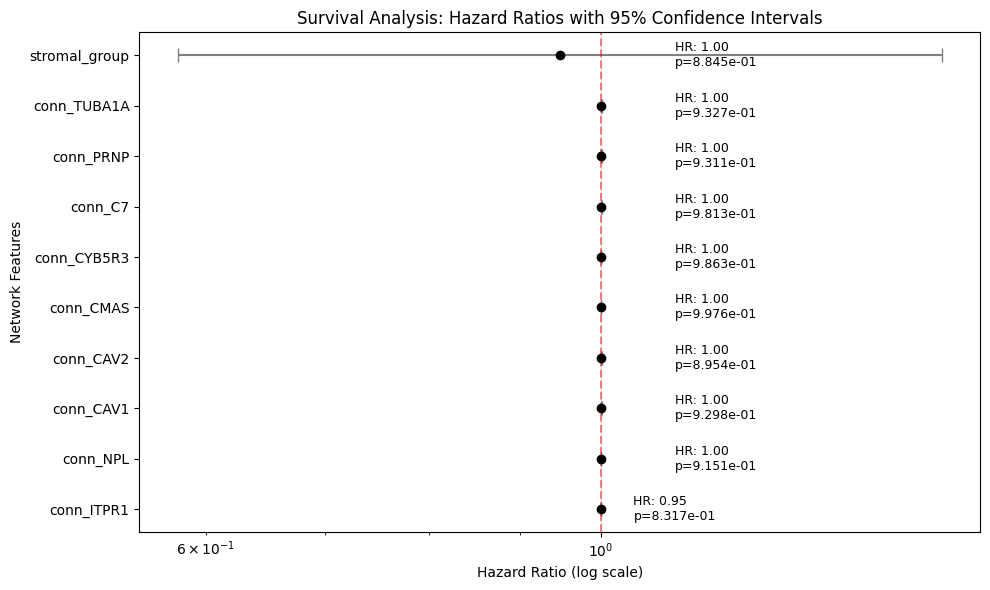

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_survival_results(cph_summary):
    # Prepare data
    results = cph_summary.reset_index().rename(columns={'index': 'feature'})
    results['HR'] = np.exp(results['coef'])
    results['lower_95'] = np.exp(results['coef'] - 1.96*results['se(coef)'])
    results['upper_95'] = np.exp(results['coef'] + 1.96*results['se(coef)'])

    # Sort by hazard ratio
    results = results.sort_values('HR', ascending=False)

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot points and error bars
    plt.errorbar(results['HR'], results['covariate'],
                 xerr=[results['HR']-results['lower_95'],
                       results['upper_95']-results['HR']],
                 fmt='o', color='black', ecolor='gray', capsize=5)

    # Formatting
    plt.xscale('log')
    plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)
    plt.title('Survival Analysis: Hazard Ratios with 95% Confidence Intervals')
    plt.xlabel('Hazard Ratio (log scale)')
    plt.ylabel('Network Features')
    plt.grid(True, axis='x', alpha=0.3)

    # Annotate p-values
    for i, row in results.iterrows():
        plt.text(row['HR']*1.1, i,
                 f"HR: {row['HR']:.2f}\np={row['p']:.3e}",
                 va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# Usage after survival analysis
plot_survival_results(results)


In [ ]:
def classify(row):
    index_value = row.name
    inhibitors = ''
    treatment_drugs = ''
    colours=''
    days = 0

    if '_T' in index_value:
        colours='#f74ddb'
    elif '_N' in index_value:
        colours='green'
    else:
        colours='blue'


    return pd.Series(colours, index=['Colours'])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


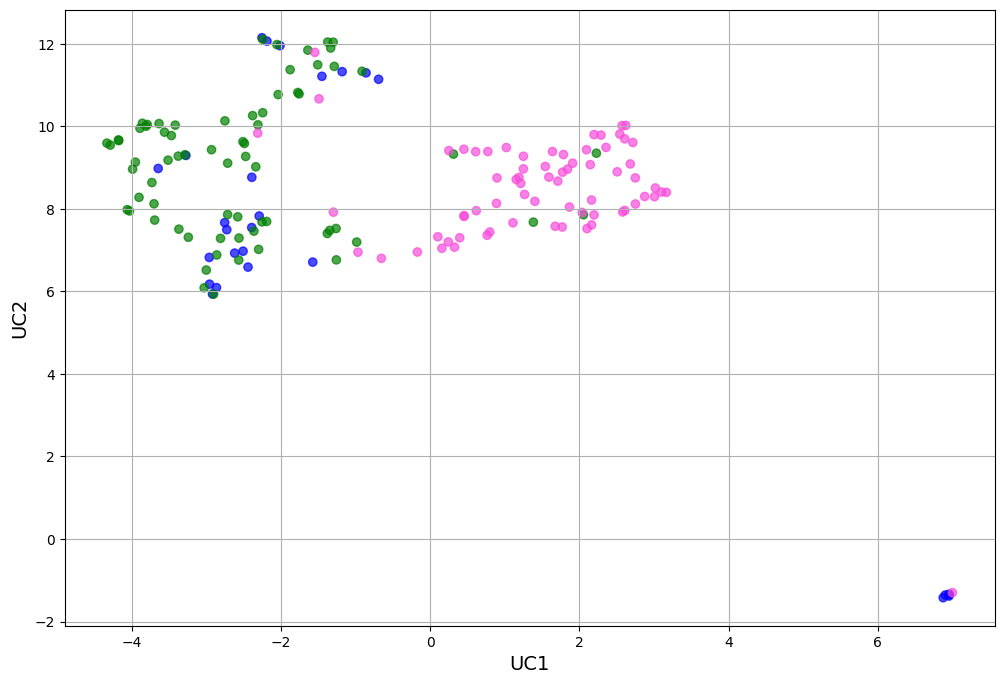

In [ ]:
import umap
from sklearn.decomposition import PCA
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, metric="cosine")

X = mbeta.T.dropna()
umap_result = reducer.fit_transform(X)

from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager

hdbscan_model = HDBSCAN(min_cluster_size=5)
hdbscan_labels = hdbscan_model.fit_predict(umap_result)


umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=X.index)
umap_df['Cluster'] = hdbscan_labels
umap_df[['Colours']] = umap_df.apply(classify, axis=1)

palette = sns.color_palette("viridis", as_cmap=True)
plt.figure(figsize=(12,8))
font = font_manager.FontProperties(weight='bold', size=14)
# Create a scatter plot for each unique subtype

plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'],
            c=umap_df['Colours'],
            label=umap_df['Colours'],
            alpha=0.7)


plt.xlabel('UC1', fontsize=14)
plt.ylabel('UC2', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
umap_df

,UMAP1,UMAP2,Cluster,Colours
E2069_B,17.113218,10.133710,0,blue
K2068_B,16.983681,10.004175,0,blue
P2055_B,16.980589,10.001027,0,blue
P2078_B,17.184906,10.205449,0,blue
S2039_B,17.110039,10.130526,0,blue
...,...,...,...,...
Y2099_T,5.776087,6.082685,6,#f74ddb
Z2015_T,5.921147,5.659955,6,#f74ddb
Z2038_T,3.934035,5.085505,6,#f74ddb
Z2061_T,6.980795,4.120502,6,#f74ddb


In [ ]:
import pandas as pd
from io import StringIO

def read_first_10_columns(file_path):
    """Reads CSV while preserving only the first 10 columns, handling edge cases."""
    processed_lines = []
    with open(file_path, 'r') as f:
        for line in f:
            # Split line into columns and keep first 10
            truncated = line.strip().split(',', 26)[:26]
            processed_lines.append(','.join(truncated))

    # Create DataFrame from processed data
    return pd.read_csv(StringIO('\n'.join(processed_lines)))

# Usage
df = read_first_10_columns('/content/CLX_methylation_cpg_annot.txt')


In [ ]:
cn

,ID,Chromosome,Start,End,Num_Markers,Mean,Label
1,A2027,1,61723,72768486,42657,0.035906,0
2,A2027,1,72768904,72811136,45,-0.949845,-1
3,A2027,1,72811904,95126689,14329,0.010824,0
4,A2027,1,95130666,95155534,63,-0.510799,-1
5,A2027,1,95155549,110232962,9082,0.007362,0
...,...,...,...,...,...,...,...
340114,Z2084,21,30360901,30380819,6,0.522088,1
341115,Z2084,21,30386751,48096945,12704,-0.012749,0
342116,Z2084,22,16055171,18624353,1119,0.022801,0
343116,Z2084,22,18624759,18629153,8,-0.593312,-1


In [ ]:
import pandas as pd

# Convert chromosome formats if necessary (e.g., "chr1" -> "1")
cn['Chromosome'] = cn['Chromosome'].replace('chr', '')
mannot.rename({'CHR':'Chromosome', 'MAPINFO':'Position'}, axis=1, inplace=True)

# Merge based on chromosome and position range
merged = pd.merge(
    mannot,
    cn,
    on='Chromosome',
    how='left'
).query('Position >= Start and Position <= End')

# Handle multiple matches (keep first occurrence)
result = merged.drop_duplicates('CpG_ID')[['CpG_ID', 'Chromosome', 'Position', 'Gene']]

# Save results
result.to_csv('cpg_gene_mapping.csv', index=False)
print(result.head())
